<a href="https://colab.research.google.com/github/rodriquiel/Optimizacion_ML_Hiperparametros/blob/main/ML_Optimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

datos = pd.read_csv("/content/drive/MyDrive/ML_Optimizacion/carros.csv")
datos.head()

,precio,vendido,edad_del_modelo,km_by_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


### Situacion con los datos ordenados de la peor manera

In [ ]:
datos_ord = datos.sort_values("vendido", ascending=True)
x_ord = datos_ord[["precio", "edad_del_modelo","km_by_year"]]
y_ord = datos_ord["vendido"]
datos_ord.head()

,precio,vendido,edad_del_modelo,km_by_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


### Se utiliza un Dummy classifier para poder establecer una baseline, y poder saber cual de los modelos aplicados posteriormente es mejor que este modelo por defecto

El Dummy classifier es un modelo estadistico que se va a basar en la cantidad de ceros y unos en la base de datos

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con dummy stratified, 10 = [58.00, 58.00]


### Arbol de decision

Se puede observar una mejora con respecto de la baseline

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con cross validation, 10 = [73.83, 77.73]


### Generando datos aleatorios del modelo de carro

Se pueden en algunos casos donde se tienen pocas variables, cuando el resultado del modelo, del accuracy o la precisión del modelo no pasa de un número, crear agrupaciones o agregaciones con los datos que se tienen y dichas agregaciones incluirlas como un nuevo feature dentro de los datos para, tal vez predecir un resultado medio mejor con esta nueva variable.

Se crea la variable 'modelo'. Ahora este modelo es nada más que un valor aleatorio encima de los datos que ya existen, en este caso se utiliza la columna 'edad_del_modelo' y se suma un valor aleatorio encima de este valor

In [ ]:
np.random.seed(SEED)
datos['modelo'] = datos.edad_del_modelo + np.random.randint(-2, 3, size=10000)
datos.modelo = datos.modelo + abs(datos.modelo.min()) + 1
datos.head()

,precio,vendido,edad_del_modelo,km_by_year,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


###Creacion funcion que retorna valores estadisticos como media, dispersion, desviacion

In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desviacion = results['test_score'].std() * 100
  print("Accuracy media %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desviacion, media + 2 * desviacion))

###Validacion cruzada sobre arbol de decision (GroupKFold)

In [ ]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 75.78
Intervalo [73.67, 77.90]


En este caso, no se ve una diferencia sustancial en los resultados de los modelos

###Support Vector Machine

In [ ]:
# GroupKFold en un pipeline con StandardScaler y SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacion',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 76.68
Intervalo [74.28, 79.08]


Se puede ver una leve mejoria en la performance del modelo en comparacion con los aplicados anteriormente

### Trabajo sobre arbol de decision



In [ ]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 75.78
Intervalo [73.67, 77.90]


Modelo de profundidad 2

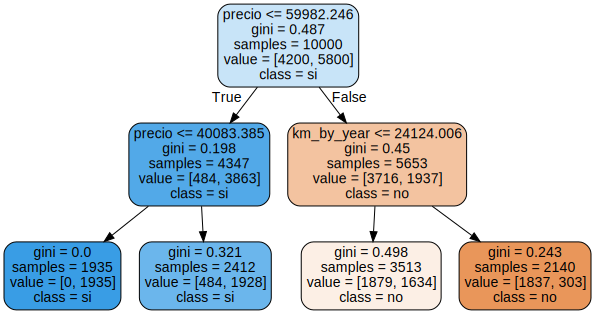

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord, y_ord)
#Columnas pertenecientes a 'x', es decir, aquellas que no precisan de una prediccion
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['no','si'], feature_names = features)
graph = graphviz.Source(dot_data)
graph

Modelo de profundidad 3

In [ ]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 78.67
Intervalo [76.40, 80.94]


Se puede observar una mejora en la precision del modelo

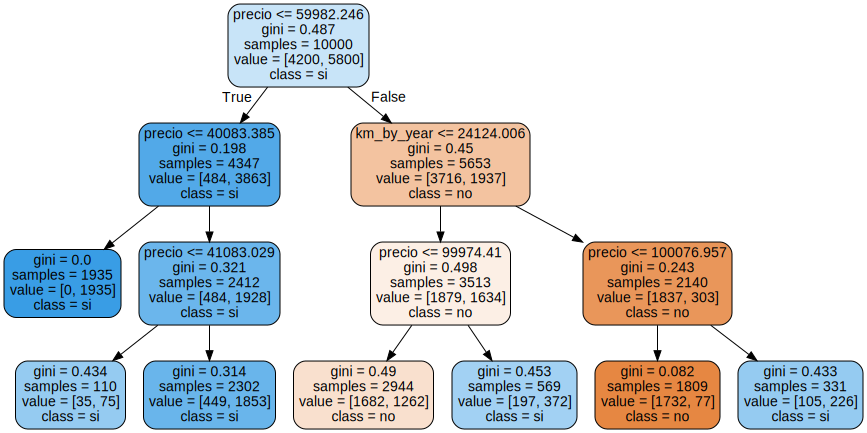

In [ ]:
modelo.fit(x_ord, y_ord)
#Columnas pertenecientes a 'x', es decir, aquellas que no precisan de una prediccion
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['no','si'], feature_names = features)
graph = graphviz.Source(dot_data)
graph

No por aumentar ed manera progresiva la profundidad significa que se van a obtener mejores resultados, para este tipo de moldeos simepre se alcanza un valor del profundidad donde el modelo comienza a perder precision. Esto se puede ver colocando una profundidad de 10 en el modelo y observar los resultados

In [ ]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 77.19
Intervalo [75.26, 79.13]


Optimizar modelos no significa colocar más valores en los parámetros o utilizar una mayor profundidad del árbol de decisión que se esta modelando, significa utilizar el mejor parámetro y el mejor valor que proporcione el mejor valor o accuracy o precisión de nuestro modelo.

## Utilizacion de hiperparametros

El DecisionTreeClassifier que se utiliza para dar forma al modelo permite la entrada de distintos parametros, los cuales se los denomina hiperparametros, como por ejemplo el caso de la profundidad maxina (max_depth). Son configuraciones que se colocan previo al entrenamiento del modelo.

Los parametros propiamente dichos son aquellos resultados obtenidos luego del entrenamiento del modelo, es decir, se generan durante el entrenamiento del mismo.

### Prueba de hiperparametros

In [ ]:
def iniciar_arbol_decision(profundidad):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = profundidad)
  results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
  test_score = results['test_score'].mean()*100
  print('Profundidad = %d, testing = %.2f' % (profundidad,test_score))


Se prueba la funcion con un resultado conocido de profundidad

In [ ]:
iniciar_arbol_decision(3)

Profundidad = 3, testing = 78.67


### Ahora, se busca dentro de las profundidades desde 1 hasta 32 cual es la que mejor performance tiene

In [ ]:
for i  in range(1,33):
  iniciar_arbol_decision(i)

Profundidad = 1, testing = 75.78
Profundidad = 2, testing = 75.78
Profundidad = 3, testing = 78.67
Profundidad = 4, testing = 78.63
Profundidad = 5, testing = 78.56
Profundidad = 6, testing = 78.12
Profundidad = 7, testing = 77.96
Profundidad = 8, testing = 77.86
Profundidad = 9, testing = 77.38
Profundidad = 10, testing = 77.19
Profundidad = 11, testing = 76.97
Profundidad = 12, testing = 76.49
Profundidad = 13, testing = 75.81
Profundidad = 14, testing = 75.66
Profundidad = 15, testing = 75.16
Profundidad = 16, testing = 75.11
Profundidad = 17, testing = 74.74
Profundidad = 18, testing = 74.33
Profundidad = 19, testing = 74.34
Profundidad = 20, testing = 74.22
Profundidad = 21, testing = 73.80
Profundidad = 22, testing = 73.81
Profundidad = 23, testing = 73.38
Profundidad = 24, testing = 73.43
Profundidad = 25, testing = 73.14
Profundidad = 26, testing = 73.04
Profundidad = 27, testing = 72.91
Profundidad = 28, testing = 72.66
Profundidad = 29, testing = 72.73
Profundidad = 30, testi

A mayor profundidad se deberia estar obteniendo un modelo mas 'inteligente', pero esto no sucede porque los datos en el entrenamiento 'aprenden' de muy buena manera pero no estan preparados para los datos de pureba, por eso es que el modelo no muestra mejorias al aumentar la profundidad. Es decir, los datos funcionan bien en el entorno de entrenamiento pero al aplicarlo a un caso real no se visualiza dicho aprendizaje. A esto se lo denomina **'Overfitting'**.

Analisis con valor de entrenamiento

In [ ]:
def iniciar_arbol_decision(profundidad):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = profundidad)
  results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
  test_score = results['test_score'].mean()*100
  train_score = results['train_score'].mean()*100
  print('Profundidad = %d, testing = %.2f, training = %.2f' % (profundidad,test_score,train_score))
  tabla = [profundidad, test_score, train_score]
  return tabla

In [ ]:
resultados = [iniciar_arbol_decision(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns = ['profundidad','test','train'])
resultados.head(10)

Profundidad = 1, testing = 75.78, training = 75.79
Profundidad = 2, testing = 75.78, training = 75.79
Profundidad = 3, testing = 78.67, training = 78.75
Profundidad = 4, testing = 78.63, training = 78.79
Profundidad = 5, testing = 78.56, training = 78.94
Profundidad = 6, testing = 78.12, training = 79.17
Profundidad = 7, testing = 77.96, training = 79.50
Profundidad = 8, testing = 77.86, training = 79.89
Profundidad = 9, testing = 77.38, training = 80.46
Profundidad = 10, testing = 77.19, training = 81.16
Profundidad = 11, testing = 76.97, training = 82.03
Profundidad = 12, testing = 76.49, training = 82.89
Profundidad = 13, testing = 75.81, training = 83.95
Profundidad = 14, testing = 75.66, training = 85.03
Profundidad = 15, testing = 75.16, training = 86.14
Profundidad = 16, testing = 75.11, training = 87.19
Profundidad = 17, testing = 74.74, training = 88.31
Profundidad = 18, testing = 74.33, training = 89.26
Profundidad = 19, testing = 74.34, training = 90.32
Profundidad = 20, tes

,profundidad,test,train
0,1,75.784219,75.791169
1,2,75.784219,75.791169
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007
5,6,78.123266,79.170115
6,7,77.963185,79.496806
7,8,77.857951,79.887810
8,9,77.376956,80.459009
9,10,77.194204,81.158994


Se puede observar como a medida que aumenta la profundidad, el dato de entrenamiento mejora de manera progresiva mientra que el dato de prueba no tiene el mismo comportamiento, por lo que, como se menciono anteriormente, se trata de un problema de overfitting

Se puede observar mejor el comportamiento en el siguiente grafico, donde la linea azul representa a los datos de entrenamiento, y la linea naranja representa a los datos de prueba

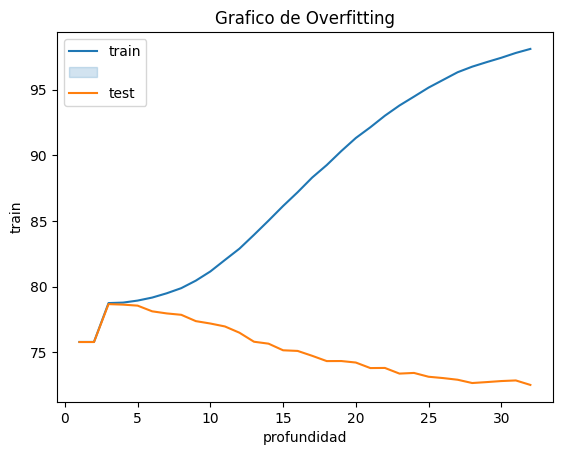

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x = 'profundidad', y='train', data = resultados);
sns.lineplot(x = 'profundidad', y='test', data = resultados);
plt.legend(['train','','test']);
plt.title('Grafico de Overfitting');

Ordenamiento de resultados de mayor a menor en base a datos de prueba

In [ ]:
resultados.sort_values('test', ascending = False).head()

,profundidad,test,train
2,3,78.672633,78.750993
3,4,78.632803,78.787628
4,5,78.555912,78.941007
5,6,78.123266,79.170115
6,7,77.963185,79.496806


## Exploracion sobre hiperparametros en dos dimensiones

### Se agrega el hiperparametro 'min_samples_leaf', que permite asignar el número mínimo de muestras requeridas para estar en un nodo hoja.

In [ ]:
def iniciar_arbol_decision(profundidad, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = profundidad, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
  test_score = results['test_score'].mean()*100
  train_score = results['train_score'].mean()*100
  print('Profundidad = %d, min_samples_leaf = %d, testing = %.2f, training = %.2f' % (profundidad,min_samples_leaf,test_score,train_score))
  tabla = [profundidad, min_samples_leaf, test_score, train_score]
  return tabla

In [ ]:
def buscar():
  resultados = []
  for profundidad in range(1,32):
    for min_samples_leaf in [32,64,128,256]: #se toma esos valores arbitrarios para reducir tiempos de ejecucion
      tabla = iniciar_arbol_decision(profundidad,min_samples_leaf)
      resultados.append(tabla)
  resultados = pd.DataFrame(resultados, columns=['max_depth','min_samples_leaf','testing','training'])
  return resultados

In [ ]:
resultados = buscar()
resultados.head(10)

Profundidad = 1, min_samples_leaf = 32, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 256, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 32, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 64, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 128, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 256, testing = 75.78, training = 75.79
Profundidad = 3, min_samples_leaf = 32, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 64, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 128, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 256, testing = 78.67, training = 78.75
Profundidad = 4, min_samples_leaf = 32, testing = 78.67, training = 78.75
Profundidad = 4, min_samples_lea

,max_depth,min_samples_leaf,testing,training
0,1,32,75.784219,75.791169
1,1,64,75.784219,75.791169
2,1,128,75.784219,75.791169
3,1,256,75.784219,75.791169
4,2,32,75.784219,75.791169
5,2,64,75.784219,75.791169
6,2,128,75.784219,75.791169
7,2,256,75.784219,75.791169
8,3,32,78.672633,78.750993
9,3,64,78.672633,78.750993


Ordenamiento de resultados de mayor a menor en base a datos de prueba

In [ ]:
resultados.sort_values('testing', ascending = False).head()

,max_depth,min_samples_leaf,testing,training
11,3,256,78.672633,78.750993
8,3,32,78.672633,78.750993
15,4,256,78.672633,78.750993
14,4,128,78.672633,78.750993
13,4,64,78.672633,78.750993


Estos resultados se obtuvieron utilizando 4 valores arbitrarios para el hiperparametro 'min_samples_leaf', pero realizando dicha accion puede que se este perdiendo algun valor que permite una mejor performance del modelo. Para analizar cuales son los mejores valores o los mas convenientes se utiliza una matriz de correlacion

##Matriz de correlacion

In [ ]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,testing,training
max_depth,1.000000e+00,-2.819789e-16,-0.024381,0.546146
min_samples_leaf,-2.819789e-16,1.000000e+00,0.341805,-0.401773
testing,-2.438091e-02,3.418055e-01,1.000000,0.133720
training,5.461464e-01,-4.017734e-01,0.133720,1.000000


Se puede observar la relacion directa o inversa entre cada variable y el grado de dicha correlacion. Se puede ver tambien de forma grafica

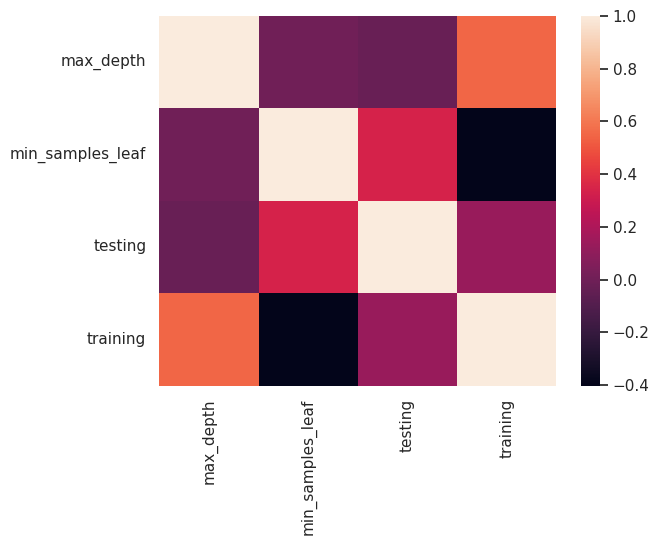

In [ ]:
sns.heatmap(corr);

Se puede ver en ambos resultados que a mayor profundidad, los datos de entrenamiento mejoran (relacion proporcional) y los datos de prueba empeoran (relacion inversamente proporcional)

Para el caso de 'min_samples_leaf', se ve que a mayor valor de este, menor es el valor en los datos de entrenamiento y mayor es el valor en los datos de prueba

###Otras maneras de ver las correlaciones

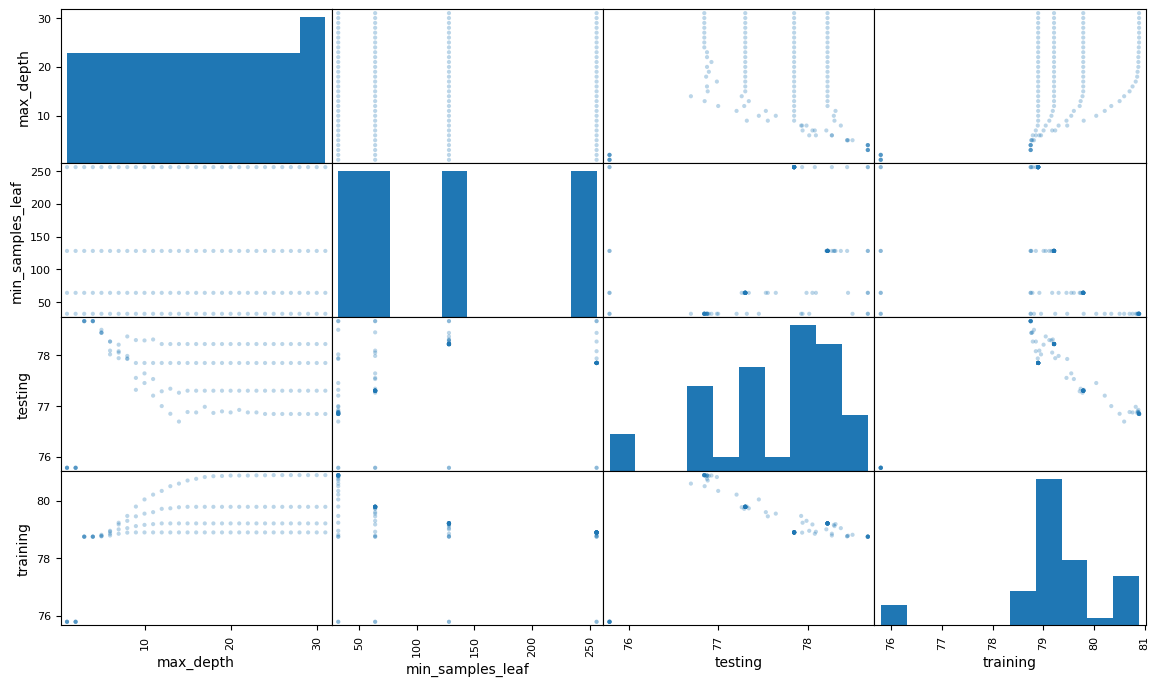

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(resultados, figsize = (14,8), alpha = 0.3);

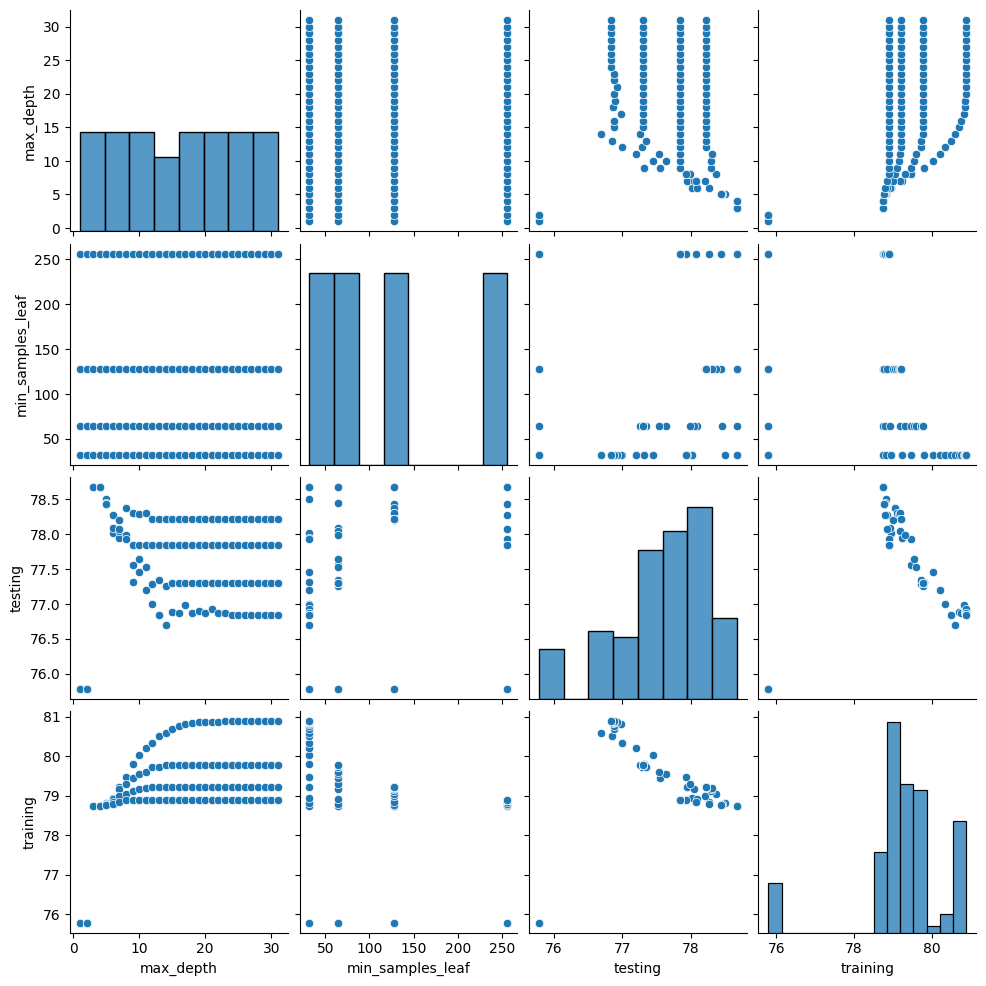

In [ ]:
sns.pairplot(resultados);

###Correlacion diagonal con Seaborn

<Axes: >

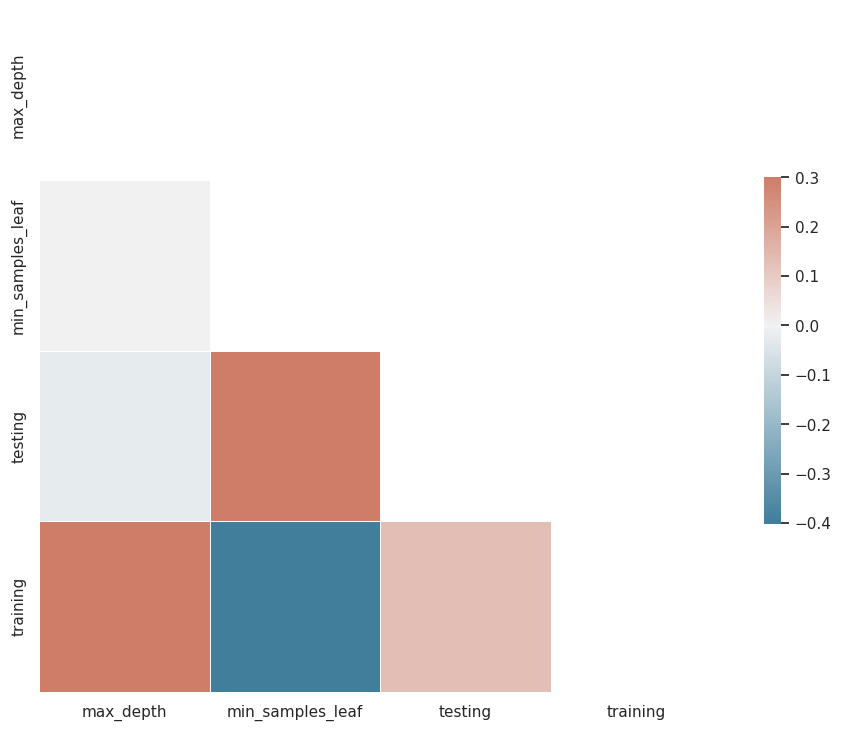

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Se puede observar mediante todos estos graficos que el test va a funcionar bien para bajos valores del max_depth y altos valores del min_samples_leaf. Entonces esta es la combinación perfecta que entrega la matriz de correlación para saber qué valores colocar en los hiperparámetros.

Entonces, se aplica una cota maxima de 10 a la profundidad y y un rango de valores entre 130 y 250 aproximadamente para el 'min_samples_leaf'. Esto no quiere decir que haya que tomar todos los valores de ese rango, sino algunos de manera arbitraria dentro de ese rango para no causar largos tiempos de ejecucion del programa

In [ ]:
def buscar():
  resultados = []
  for profundidad in range(1,10):
    for min_samples_leaf in [128,190,220,256]: #se toma esos valores arbitrarios para reducir tiempos de ejecucion
      tabla = iniciar_arbol_decision(profundidad,min_samples_leaf)
      resultados.append(tabla)
  resultados = pd.DataFrame(resultados, columns=['max_depth','min_samples_leaf','testing','training'])
  return resultados

In [ ]:
resultados = buscar()
resultados.head(10)

Profundidad = 1, min_samples_leaf = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 190, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 220, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 256, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 128, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 190, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 220, testing = 75.78, training = 75.79
Profundidad = 2, min_samples_leaf = 256, testing = 75.78, training = 75.79
Profundidad = 3, min_samples_leaf = 128, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 190, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 220, testing = 78.67, training = 78.75
Profundidad = 3, min_samples_leaf = 256, testing = 78.67, training = 78.75
Profundidad = 4, min_samples_leaf = 128, testing = 78.67, training = 78.75
Profundidad = 4, min_samp

,max_depth,min_samples_leaf,testing,training
0,1,128,75.784219,75.791169
1,1,190,75.784219,75.791169
2,1,220,75.784219,75.791169
3,1,256,75.784219,75.791169
4,2,128,75.784219,75.791169
5,2,190,75.784219,75.791169
6,2,220,75.784219,75.791169
7,2,256,75.784219,75.791169
8,3,128,78.672633,78.750993
9,3,190,78.672633,78.750993


In [ ]:
resultados.sort_values('testing', ascending = False).head()

,max_depth,min_samples_leaf,testing,training
13,4,190,78.672633,78.750993
11,3,256,78.672633,78.750993
15,4,256,78.672633,78.750993
14,4,220,78.672633,78.750993
12,4,128,78.672633,78.750993


Se puede observar que con un numero mucho menor de iteraciones de la profundidad y valores diferentes dentro del min_samples_leaf, se obtuvo un resultado con igual performance que en el primer caso analizado con los mismos hiperparametros

##Aplicacion de 3 o mas hiperparametros

###Se analiza si el algoritmo aplicado para dos hiperparametros es igualmente funcional para una mayor cantidad de los mismos

En este caso, se utiliza el hiperparametro 'min_samples_split', que permite seleccionar el numero de nodos en que se divide un nodo

Se agrega tambien al DataFrame los tiempos de ejecucion, con el fin de analizarlos al obtener los resultados

In [ ]:
def iniciar_arbol_decision(profundidad, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth = profundidad, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
  test_score = results['test_score'].mean()*100
  train_score = results['train_score'].mean()*100
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  print('Profundidad = %d, min_samples_leaf = %d, min_samples_split = %d, testing = %.2f, training = %.2f' % (profundidad,min_samples_leaf,min_samples_split,test_score,train_score))
  tabla = [profundidad, min_samples_leaf, min_samples_split, test_score, train_score, score_time, fit_time]
  return tabla

Se comienza utilizando los mismos datos que en el caso anterior y se adiciona el nuevo hiperparametro, para luego analizar la correlacion

In [ ]:
def buscar():
  resultados = []
  for profundidad in range(1,32):
    for min_samples_leaf in [32,64,128,256]:
      for min_samples_split in [32,64,128,256]:
        tabla = iniciar_arbol_decision(profundidad,min_samples_leaf,min_samples_split)
        resultados.append(tabla)
  resultados = pd.DataFrame(resultados, columns=['max_depth','min_samples_leaf','min_samples_split','testing','training','score_time','fit_time'])
  return resultados

In [ ]:
resultados = buscar()
resultados.head(10)

Profundidad = 1, min_samples_leaf = 32, min_samples_split = 32, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 64, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 256, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 32, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 64, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 256, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 128, min_samples_split = 32, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 128, min_samples_split = 64, testing = 75.78, training = 75.79
Profundidad = 

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
0,1,32,32,75.784219,75.791169,0.002381,0.006805
1,1,32,64,75.784219,75.791169,0.002183,0.006067
2,1,32,128,75.784219,75.791169,0.002010,0.006225
3,1,32,256,75.784219,75.791169,0.002120,0.006130
4,1,64,32,75.784219,75.791169,0.002592,0.006746
5,1,64,64,75.784219,75.791169,0.002266,0.006331
6,1,64,128,75.784219,75.791169,0.002739,0.006214
7,1,64,256,75.784219,75.791169,0.001872,0.005941
8,1,128,32,75.784219,75.791169,0.002324,0.006232
9,1,128,64,75.784219,75.791169,0.002115,0.006175


In [ ]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
max_depth,1.000000e+00,1.642886e-16,3.990718e-16,0.015135,0.538343,0.185930,0.570857
min_samples_leaf,1.642886e-16,1.000000e+00,9.965536e-19,0.280463,-0.334243,-0.128703,-0.494787
min_samples_split,3.990718e-16,9.965536e-19,1.000000e+00,0.130175,-0.123452,-0.055917,-0.059699
testing,1.513479e-02,2.804627e-01,1.301748e-01,1.000000,0.263804,-0.076751,-0.042149
training,5.383434e-01,-3.342432e-01,-1.234515e-01,0.263804,1.000000,0.188234,0.842030
score_time,1.859304e-01,-1.287029e-01,-5.591662e-02,-0.076751,0.188234,1.000000,0.481065
fit_time,5.708567e-01,-4.947871e-01,-5.969881e-02,-0.042149,0.842030,0.481065,1.000000


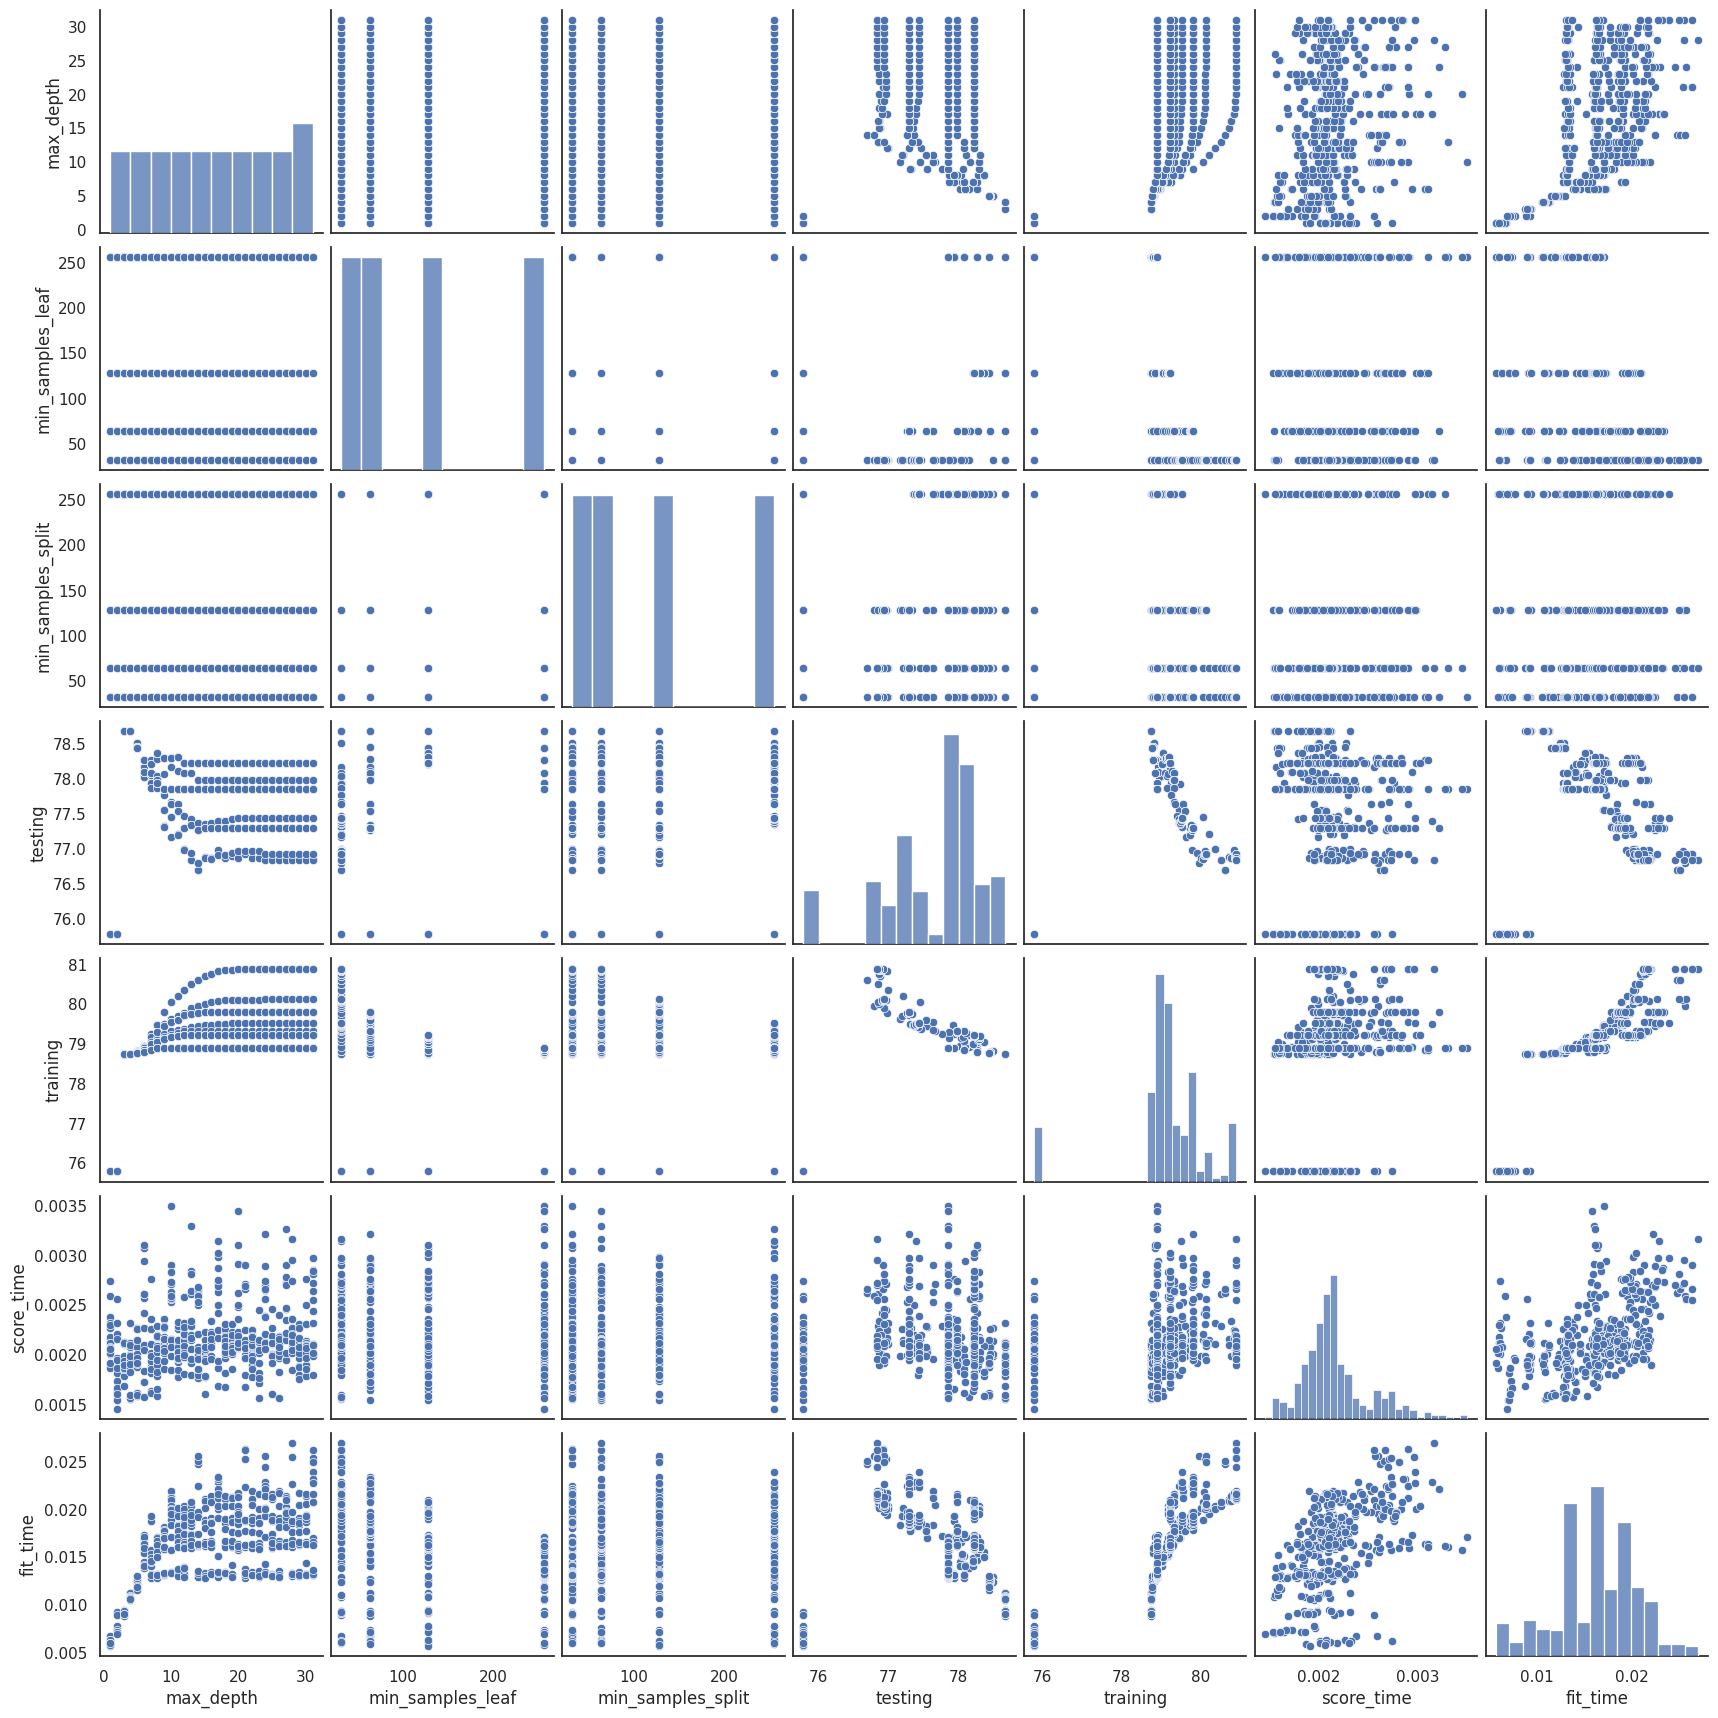

In [ ]:
sns.pairplot(resultados);

<Axes: >

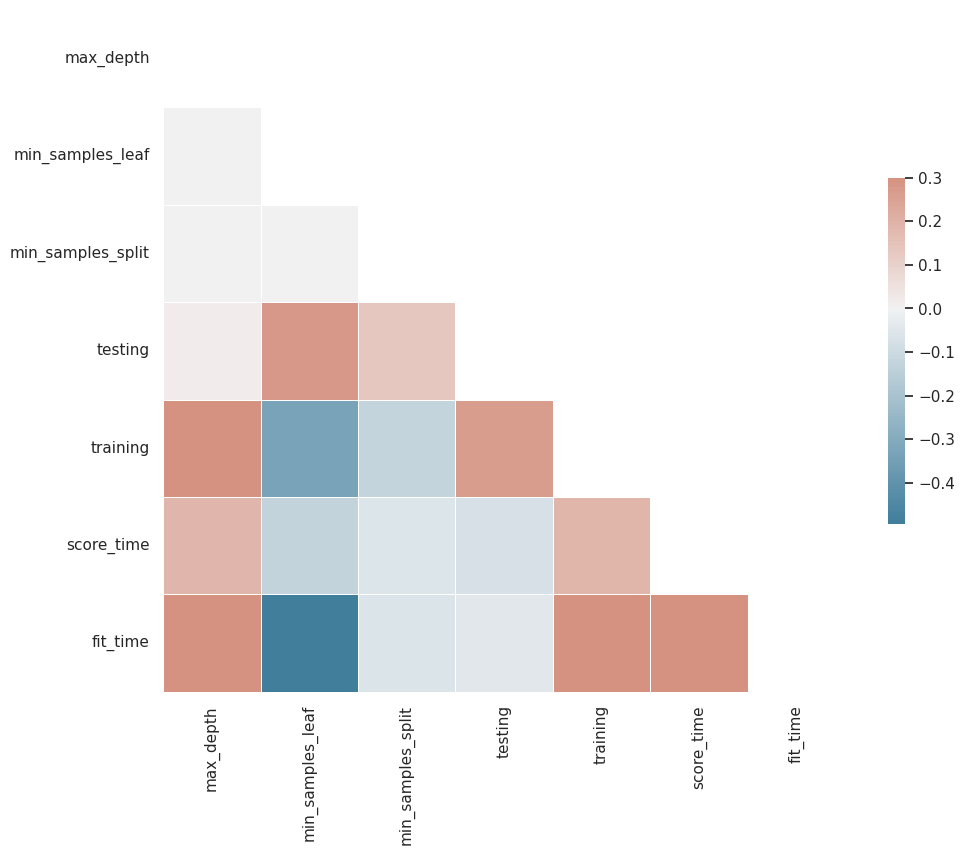

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
resultados.sort_values('testing', ascending = False).head()

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
45,3,256,64,78.672633,78.750993,0.002124,0.009345
41,3,128,64,78.672633,78.750993,0.001989,0.009247
48,4,32,32,78.672633,78.750993,0.001556,0.010895
47,3,256,256,78.672633,78.750993,0.001896,0.009052
46,3,256,128,78.672633,78.750993,0.001868,0.009106


Analizando los resultados obtenidos junto con la matriz de correlacion, para este caso se toma que con una profundidad variando en un rango de 0 a 10, un min_samples_leaf tomando valores dentro de un rango de 0 a 100 y un min_samples_split tomando valores dentro en un rango de 0 a 150 se deberian obtener buenas performances de los datos de test y train. Al ver los valores, se puede ver una fuerte reduccion en el numero de iteraciones de profundidad, lo que impacta direnctamente en un reduccion del tiempo de ejecucion total del calculo del resultado

In [ ]:
def buscar():
  resultados = []
  for profundidad in range(1,10):
    for min_samples_leaf in [15,32,64,100]:
      for min_samples_split in [28,75,128,150]:
        tabla = iniciar_arbol_decision(profundidad,min_samples_leaf,min_samples_split)
        resultados.append(tabla)
  resultados = pd.DataFrame(resultados, columns=['max_depth','min_samples_leaf','min_samples_split','testing','training','score_time','fit_time'])
  return resultados

In [ ]:
resultados = buscar()
resultados.head(10)

Profundidad = 1, min_samples_leaf = 15, min_samples_split = 28, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 15, min_samples_split = 75, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 15, min_samples_split = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 15, min_samples_split = 150, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 28, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 75, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 128, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 32, min_samples_split = 150, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 28, testing = 75.78, training = 75.79
Profundidad = 1, min_samples_leaf = 64, min_samples_split = 75, testing = 75.78, training = 75.79
Profundidad = 1,

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
0,1,15,28,75.784219,75.791169,0.001746,0.005564
1,1,15,75,75.784219,75.791169,0.001682,0.004973
2,1,15,128,75.784219,75.791169,0.001678,0.005079
3,1,15,150,75.784219,75.791169,0.001717,0.004651
4,1,32,28,75.784219,75.791169,0.001589,0.005154
5,1,32,75,75.784219,75.791169,0.001583,0.004853
6,1,32,128,75.784219,75.791169,0.001645,0.005138
7,1,32,150,75.784219,75.791169,0.001962,0.005179
8,1,64,28,75.784219,75.791169,0.001611,0.004780
9,1,64,75,75.784219,75.791169,0.002220,0.006196


In [ ]:
resultados.sort_values('testing', ascending = False).head()

,max_depth,min_samples_leaf,min_samples_split,testing,training,score_time,fit_time
60,4,100,28,78.672633,78.750993,0.001943,0.010841
55,4,32,150,78.672633,78.750993,0.002115,0.010978
58,4,64,128,78.672633,78.750993,0.001987,0.011188
57,4,64,75,78.672633,78.750993,0.002062,0.011483
56,4,64,28,78.672633,78.750993,0.002175,0.011102


## Busqueda de hiperparametros con GridSearchCV

Se trata de una búsqueda exhaustiva sobre valores de parámetros específicos para un estimador.

In [ ]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

#Especificacion de valores que puede tomar cada hiperparametro
espacio_parametros = {
    'max_depth': [3,5],
    'min_samples_leaf': [32,64,128],
    'min_samples_split': [32,64,128],
    'criterion': ['gini','entropy']
}

#aplicacion del GridSearchCV
buscar = GridSearchCV(DecisionTreeClassifier(),
                      espacio_parametros,
                      cv = GroupKFold(n_splits = 10)
                      )
buscar.fit(x_ord,y_ord, groups = datos.modelo)
resultados = pd.DataFrame(buscar.cv_results_)
resultados.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009543,0.000519,0.002147,0.000372,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.009439,0.000488,0.002020,0.000274,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.009426,0.000407,0.002129,0.000370,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.009532,0.000367,0.002195,0.000230,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.009543,0.000646,0.002218,0.000264,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


Este metodo ofrece un resultado en base a datos similar al desarrollado de manera 'manual' anteriormente, devolviendo lo obtenido con el metodo anteriormente aplicado y algunas variables mas que tambien pueden resultar de utlilidad. El metodo ofrece una solucion mas elegante para llegar a un resultado similar

Tambien, permite mediante un atributo mostrar los mejores valores para los hiperparametros y el mejor score a partir de los mismos

In [ ]:
print(buscar.best_params_)
print(buscar.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
0.7867263337284333


###Ahora, se prueba este modelo realizando una prediccion a traves del mismo

In [ ]:
mejor = buscar.best_estimator_
mejor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [ ]:
from sklearn.metrics import accuracy_score

#Escenario optimista
prediccion = mejor.predict(x_ord)
accuracy = accuracy_score(prediccion,y_ord)*100
print("Accuracy = %.2f%%" % accuracy)


Accuracy = 78.75%


Para los datos reales, utilizando el modelo del GridSearchCV el valor es de 78.75, mejor que los resultados obtenidos con los otros métodos dentro del entrenamiento. Pero al tratarse de un modelo que aplica validacion cruzada, se debe realizar un paso más antes para tener una seguridad mayor de que esta realmente es la precisión para el mundo real

##Nestred Cross Validation

La documentacion oficial indica que al utilizar optimización a través de hiper parámetros mediante el método GridSearchCV, es necesario realizar nuevamente una validación cruzada encima del mejor modelo encontrado en el GridSearchCV. Para ello, se utiliza el método cross_val_score, que es una doble validación cruzada encima del mejor modelo

En resumen, con los hiperparametros encontrados se establecen los parámetros deseados y se realiza la validación utilizando Nested Cross Validation.

Se deben hacer algunas modificaciones ya que el metodo cross_val_score no admite el uso previo de una validación cruzada que haya utilizado el GroupKFold como atributo, y en el caso anterior se utilizó GroupKFold. Se cambia el mismo por KFold

###Primera validacion cruzada

In [ ]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

#Especificacion de valores que puede tomar cada hiperparametro
espacio_parametros = {
    'max_depth': [3,5],
    'min_samples_leaf': [32,64,128],
    'min_samples_split': [32,64,128],
    'criterion': ['gini','entropy']
}

#aplicacion del GridSearchCV
buscar = GridSearchCV(DecisionTreeClassifier(),
                      espacio_parametros,
                      cv = KFold(n_splits = 5, shuffle = True)
                      )
buscar.fit(x_ord,y_ord)
resultados = pd.DataFrame(buscar.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009634,0.001468,0.002414,0.000179,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.008804,0.000164,0.002562,0.000306,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.008599,0.000249,0.002191,0.000094,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.008293,0.000155,0.001854,0.000156,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008660,0.000409,0.002258,0.000289,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


###Segunda validacion cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(buscar, x_ord, y_ord, cv = KFold(n_splits = 5, shuffle = True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

Se obtienen nuevos valores de prediccion sobre los valores obtenidos con la primera validacion cruzada, y se entregan 5 predicciones en base a las 5 predicciones indicadas en el cv

In [ ]:
def imprime_scores(scores):
  media = scores.mean()*100
  desviacion = scores.std()*100
  print("Accuracy media = %.2f" % media)
  print("Intervalo [%.2f,%.2f]" % (media - 2 * desviacion,media + 2 * desviacion))

###Esta es la performance o la precision real sobre los datos reales

In [ ]:
imprime_scores(scores)

Accuracy media = 78.67
Intervalo [76.80,80.54]


###Ahora se puede afirmar que el modelo fue optimizado a traves de hiperparametros

###Muestra del mejor modelo y su arbol de decision correspondiente

In [ ]:
mejor = buscar.best_estimator_
mejor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

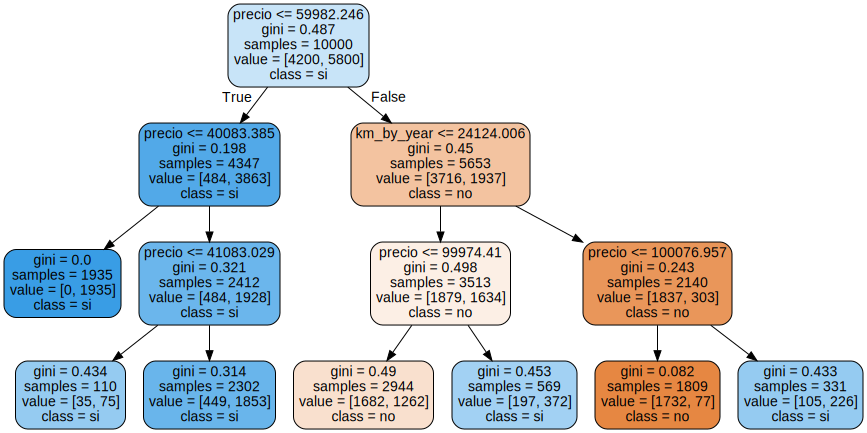

In [ ]:
features = x_ord.columns
dot_data = export_graphviz(mejor, out_file = None, filled = True, rounded = True, class_names = ['no','si'], feature_names = features)
graph = graphviz.Source(dot_data)
graph